In [2]:
from numpy import array
from os import listdir
#from google.colab import drive
#drive.mount('/content/drive')
from keras.preprocessing.image import load_img
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.callbacks import ModelCheckpoint
import os
import string
import numpy as np
import pickle
import scipy
from os import listdir
from pickle import dump
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model

from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.utils import plot_model,to_categorical
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D,Embedding,LSTM,add
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from nltk.translate.bleu_score import corpus_bleu
from keras.engine import Layer, InputSpec
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations
import keras.backend as K

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class Scale(Layer):
    '''Custom Layer for DenseNet used for BatchNormalization.
    
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:

        out = in * gamma + beta,

    where 'gamma' and 'beta' are the weights and biases larned.

    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Tensorflow >= 1.0.0 compatibility
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.2, weight_decay=1e-4, classes=100, weights_path=None):
    '''Instantiate the DenseNet 121 architecture,
        # Arguments
            nb_dense_block: number of dense blocks to add to end
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters
            reduction: reduction factor of transition blocks.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            classes: optional number of classes to classify images
            weights_path: path to pre-trained weights
        # Returns
            A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(32, 32, 3), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(3, 32, 32), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

    x = Dense(classes, name='fc6')(x)
    x = Activation('softmax', name='prob')(x)

    model = Model(img_input, x, name='densenet')

    if weights_path is not None:
      model.load_weights(weights_path)

    return model

In [0]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

In [0]:
def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x

In [0]:
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter

In [0]:
#creating a dictionary for whole dataset.
#feature[image_id] = fetures_vectore
def extract_features(directory):
    model=DenseNet121()
    model.layers.pop()
    model=Model(inputs=model.inputs,outputs=model.layers[-1].output)
    features =dict()
    for name in listdir(directory):
        filename=directory+'/'+name
        image=load_img(filename,target_size=(224,224))
        image=img_to_array(image)
        print (image.shape[2])
        image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
        image=preprocess_input(image)
        feature=model.predict(image,verbose=0)
        image_id=name.split('.')[0]
        features[image_id]=feature
    return features
#features=extract_feature("Flicker8k_Dataset")
#dump(features,open("features.pkl","wb"))

In [0]:
#cleaning the descrioption and creating a dictionary for description
def load_text(filename):
    file=open(filename,errors="ignore")
    text=file.read()
    file.close()
    return (text)
def load_desc(doc):
    descriptions=dict()
    for line in doc.split('\n'):
        token=line.split()
        if len(line)<2:
            continue
        img_id,img_desc=token[0],token[1:]
        img_id=img_id.split('.')[0]
        print (img_id)
        img_desc=' '.join(img_desc)
        if not img_id in descriptions:
            descriptions[img_id]=list()
        descriptions[img_id].append(img_desc)
    return descriptions
        
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc
 
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
 


'''text=load_text("Flicker8k_Text/Flickr8k.token.txt")
desc=load_desc(text)
clean_descriptions(desc)
vocab=to_vocabulary(desc)
print (desc["1030985833_b0902ea560"][0])
save_descriptions(desc,"description.txt")'''

    

'text=load_text("Flicker8k_Text/Flickr8k.token.txt")\n#print (text)\ndesc=load_desc(text)\n#print (text)\nclean_descriptions(desc)\nvocab=to_vocabulary(desc)\n#print (desc["1030985833_b0902ea560"][0])\n#save_descriptions(desc,"description.txt")\n'

In [0]:
#dividing the training and testing data 
def load_identifier(doc):
    identifier=list()
    for line in doc.split('\n'):
        img_id=line.split('.')[0]
        identifier.append(img_id)
    return set(identifier)
def load_train_desc(filename,dataset):
    desc=dict()
    text = load_text(filename)
    for line in text.split('\n'):
        token=line.split()
        img_id,img_desc=token[0],token[1:]
        if img_id in dataset:
            if img_id not in desc.keys():
                desc[img_id]=list()
            img_desc = 'startseq ' + ' '.join(img_desc) + ' endseq'
            desc[img_id].append(img_desc)
    return desc
def load_train_feature(filename,dataset):
    all_feat=pickle.load(open(filename,"rb"))
    features=dict()
    for k in dataset:
        if k not in all_feat:
            continue
        features[k]=all_feat[k]
    #features={k: all_feat[k] for k in dataset}
    return features



hello


In [0]:
#saving the training fetures and training description
'''#training data
doc=load_text("/Flicker8k_Text/Flickr_8k.trainImages.txt")
train=load_identifier(doc)
train_desc=load_train_desc("/description.txt",train)
train_features=load_train_feature("/features.pkl",train)
np.save("/training_data/train_desc.npy",train_desc)
np.save("/training_data/train_features.npy",train_features)
print (len(train_desc))
print (len(train_features))
'''

'#training data\ndoc=load_text("/content/drive/My Drive/major_project/Flicker8k_Text/Flickr_8k.trainImages.txt")\ntrain=load_identifier(doc)\ntrain_desc=load_train_desc("/content/drive/My Drive/major_project/description.txt",train)\ntrain_features=load_train_feature("/content/drive/My Drive/major_project/features.pkl",train)\nnp.save("/content/drive/My Drive/major_project/training_data/train_desc.npy",train_desc)\nnp.save("/content/drive/My Drive/major_project/training_data/train_features.npy",train_features)\nprint (len(train_desc))\nprint (len(train_features))\n'

In [0]:
#saving the testing feature and testing description
'''
doc=load_text("/content/drive/My Drive/major_project/Flicker8k_Text/Flickr_8k.testImages.txt")
test=load_identifier(doc)
test_desc=load_train_desc("/content/drive/My Drive/major_project/description.txt",test)
test_features=load_train_feature("/content/drive/My Drive/major_project/features.pkl",test)
np.save("/content/drive/My Drive/major_project/testing_data/test_desc.npy",test_desc)
np.save("/content/drive/My Drive/major_project/testing_data/test_features.npy",test_features)
print (len(test_desc))
print (len(test_features))'''

'#testing data\ndoc=load_text("/content/drive/My Drive/major_project/Flicker8k_Text/Flickr_8k.testImages.txt")\ntest=load_identifier(doc)\ntest_desc=load_train_desc("/content/drive/My Drive/major_project/description.txt",test)\ntest_features=load_train_feature("/content/drive/My Drive/major_project/features.pkl",test)\nnp.save("/content/drive/My Drive/major_project/testing_data/test_desc.npy",test_desc)\nnp.save("/content/drive/My Drive/major_project/testing_data/test_features.npy",test_features)\nprint (len(test_desc))\nprint (len(test_features))'

In [0]:
'''def to_lines(desc):
    all_desc=list()
    for key in desc.keys():
        [all_desc.append(d) for d in desc[key]]
    return all_desc
def create_tokenizer(desc):
    lines=to_lines(desc)
    tokenizer =Tokenizer()
    tokenizer.fit_on_texts(lines)
    print (lines)
    return tokenizer
tokenizer=create_tokenizer(train_desc)
#tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('/content/drive/My Drive/major_project/tokenizer.pkl', 'wb'))
vocab_size=len(tokenizer.word_index)+1
print (vocab_size)'''

"def to_lines(desc):\n    all_desc=list()\n    for key in desc.keys():\n        [all_desc.append(d) for d in desc[key]]\n    return all_desc\ndef create_tokenizer(desc):\n    lines=to_lines(desc)\n    tokenizer =Tokenizer()\n    tokenizer.fit_on_texts(lines)\n    print (lines)\n    return tokenizer\ntokenizer=create_tokenizer(train_desc)\n#tokenizer = create_tokenizer(train_descriptions)\n# save the tokenizer\ndump(tokenizer, open('/content/drive/My Drive/major_project/tokenizer.pkl', 'wb'))\nvocab_size=len(tokenizer.word_index)+1\nprint (vocab_size)"

In [0]:
#model of image captioning (densenet+LSTM)
def define_model(vocab_size,max_length):
    inputs1=Input(shape=(1024,))
    fe1=Dropout(0.5)(inputs1)
    fe2=Dense(256,activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    #model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    #plot_model(model, to_file='model.png', show_shapes=True)
    return model
    

In [11]:
#loading trainig data
train_desc=np.load("/content/drive/My Drive/15IT208_15IT101_15IT107_15IT246_major_project/training_data/train_desc.npy",allow_pickle=True).item()
train_features=np.load("/content/drive/My Drive/15IT208_15IT101_15IT107_15IT246_major_project/training_data/train_features.npy",allow_pickle=True).item()
'''X1train,X2train,ytrain=create_sequences(tokenizer,max_length,train_desc,train_features)
#model.fit([X1train, X2train], ytrain, epochs=20, verbose=2)
X1train = np.asarray(X1train)
X2train = np.asarray(X2train)
ytrain = np.asarray(ytrain)
'''

'X1train,X2train,ytrain=create_sequences(tokenizer,max_length,train_desc,train_features)\n#model.fit([X1train, X2train], ytrain, epochs=20, verbose=2)\nX1train = np.asarray(X1train)\nX2train = np.asarray(X2train)\nytrain = np.asarray(ytrain)\n'

In [0]:
#extracting the feature vector for a particular image
def extract_feature(filename):
	# load the model
	model = DenseNet121()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

# load the tokenizer
#tokenizer = load(open('/content/drive/My Drive/major_project/tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
#model = load_model('/content/drive/My Drive/major_project/model/model_19.h5')

In [13]:
#Create a list of all the training captions
all_train_captions = []
for key,desc in train_desc.items():
  [all_train_captions.append(cap) for cap in desc]
print (len(all_train_captions))
print (len(train_desc))

30000
6000


In [17]:
#consider only word which occurs at least 10 times in the corpus
word_count_threshold = 1
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents +=1
  for w in sent.split():
    word_counts[w] = word_counts.get(w,0)+1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print ('preprocessed word %d -> %d' % (len(word_counts),len(vocab)))

preprocessed word 7578 -> 7578


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [19]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

7579

In [20]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_desc)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key][0]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [23]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/15IT208_15IT101_15IT107_15IT246_major_project'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(7579, 200)

In [26]:
model=define_model(vocab_size,max_length)
model.layers[2]
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      1515800     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)  

In [0]:
'''model.fit_generator(data_generator(batch_size=128), samples_per_epoch=samples_per_epoch, nb_epoch=1, 
                          verbose=2)'''

In [0]:
'''epochs = 10
number_pics_per_bath = 3
steps = len(train_desc)//number_pics_per_bath'''

In [0]:
'''for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=2)
    #model.save('/content/drive/My Drive/major_project/full_vocab/model_1/model_' + str(i) + '.h5')'''

Epoch 1/1
 - 230s - loss: 4.8336 - acc: 0.2050
Epoch 1/1
 - 228s - loss: 4.0223 - acc: 0.2593
Epoch 1/1
 - 228s - loss: 3.7403 - acc: 0.2770
Epoch 1/1
 - 228s - loss: 3.5680 - acc: 0.2873
Epoch 1/1
 - 226s - loss: 3.4451 - acc: 0.2937
Epoch 1/1
 - 226s - loss: 3.3535 - acc: 0.2992
Epoch 1/1
 - 226s - loss: 3.2761 - acc: 0.3042
Epoch 1/1
 - 225s - loss: 3.2103 - acc: 0.3084
Epoch 1/1
 - 226s - loss: 3.1606 - acc: 0.3124
Epoch 1/1
 - 226s - loss: 3.1158 - acc: 0.3168


In [0]:
'''for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('/content/drive/My Drive/major_project/full_vocab/model_2/model_' + str(i) + '.h5')'''

Epoch 1/1
2000/2000 [==============================] - 242s 121ms/step - loss: 3.0817 - acc: 0.3196
Epoch 1/1
2000/2000 [==============================] - 242s 121ms/step - loss: 3.0452 - acc: 0.3233
Epoch 1/1
2000/2000 [==============================] - 243s 122ms/step - loss: 3.0174 - acc: 0.3255
Epoch 1/1
2000/2000 [==============================] - 243s 121ms/step - loss: 2.9932 - acc: 0.3279
Epoch 1/1
2000/2000 [==============================] - 243s 121ms/step - loss: 2.9699 - acc: 0.3295
Epoch 1/1
2000/2000 [==============================] - 243s 121ms/step - loss: 2.9497 - acc: 0.3324
Epoch 1/1
2000/2000 [==============================] - 243s 121ms/step - loss: 2.9257 - acc: 0.3339
Epoch 1/1
2000/2000 [==============================] - 243s 122ms/step - loss: 2.9108 - acc: 0.3362
Epoch 1/1
2000/2000 [==============================] - 243s 122ms/step - loss: 2.8923 - acc: 0.3383
Epoch 1/1
2000/2000 [==============================] - 244s 122ms/step - loss: 2.8749 - acc: 0.3401


In [0]:
'''model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_desc)//number_pics_per_bath'''

In [0]:
'''for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('/content/drive/My Drive/major_project/full_vocab/model_3/model_' + str(i) + '.h5')'''

Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 2.8859 - acc: 0.3398
Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 2.8587 - acc: 0.3431
Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 2.8442 - acc: 0.3441
Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 2.8272 - acc: 0.3462
Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 2.8133 - acc: 0.3478
Epoch 1/1
1000/1000 [==============================] - 136s 136ms/step - loss: 2.8018 - acc: 0.3498
Epoch 1/1
1000/1000 [==============================] - 135s 135ms/step - loss: 2.7904 - acc: 0.3503
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 2.7771 - acc: 0.3525
Epoch 1/1
1000/1000 [==============================] - 134s 134ms/step - loss: 2.7658 - acc: 0.3532
Epoch 1/1
1000/1000 [==============================] - 134s 134ms/step - loss: 2.7537 - acc: 0.3546


In [0]:
'''for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)'''

Epoch 1/1
1000/1000 [==============================] - 134s 134ms/step - loss: 2.7412 - acc: 0.3566
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 2.7314 - acc: 0.3573
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 2.7221 - acc: 0.3583
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 2.7159 - acc: 0.3601
Epoch 1/1
1000/1000 [==============================] - 132s 132ms/step - loss: 2.7053 - acc: 0.3599
Epoch 1/1
1000/1000 [==============================] - 134s 134ms/step - loss: 2.7004 - acc: 0.3615
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 2.6893 - acc: 0.3629
Epoch 1/1
1000/1000 [==============================] - 134s 134ms/step - loss: 2.6823 - acc: 0.3635
Epoch 1/1
1000/1000 [==============================] - 133s 133ms/step - loss: 2.6755 - acc: 0.3637
Epoch 1/1
1000/1000 [==============================] - 134s 134ms/step - loss: 2.6622 - acc: 0.3659


In [0]:
'''model.save_weights('/content/drive/My Drive/major_project/SGD_model/model_epoch_40.h5')'''

In [0]:
'''model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 2
steps = len(train_desc)//number_pics_per_bath
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)'''

Epoch 1/1
3000/3000 [==============================] - 402s 134ms/step - loss: 2.6437 - acc: 0.3722
Epoch 1/1
3000/3000 [==============================] - 402s 134ms/step - loss: 2.6356 - acc: 0.3735
Epoch 1/1
3000/3000 [==============================] - 399s 133ms/step - loss: 2.6274 - acc: 0.3743
Epoch 1/1
3000/3000 [==============================] - 397s 132ms/step - loss: 2.6202 - acc: 0.3750
Epoch 1/1
3000/3000 [==============================] - 399s 133ms/step - loss: 2.6151 - acc: 0.3759
Epoch 1/1
3000/3000 [==============================] - 403s 134ms/step - loss: 2.6082 - acc: 0.3763
Epoch 1/1
3000/3000 [==============================] - 401s 134ms/step - loss: 2.6054 - acc: 0.3768
Epoch 1/1
3000/3000 [==============================] - 399s 133ms/step - loss: 2.6009 - acc: 0.3783
Epoch 1/1
3000/3000 [==============================] - 400s 133ms/step - loss: 2.5959 - acc: 0.3781
Epoch 1/1
3000/3000 [==============================] - 401s 134ms/step - loss: 2.5904 - acc: 0.3786


In [0]:
'''model.save_weights('/content/drive/My Drive/major_project/SGD_model/model_epoch_50.h5')
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)'''

'for i in range(epochs):\n    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)\n    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)'

In [0]:
'''
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)'''

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1000/1000 [==============================] - 154s 154ms/step - loss: 2.8007 - acc: 0.3530
Epoch 1/1
1000/1000 [==============================] - 150s 150ms/step - loss: 2.7579 - acc: 0.3575
Epoch 1/1
1000/1000 [==============================] - 152s 152ms/step - loss: 2.7439 - acc: 0.3589
Epoch 1/1
1000/1000 [==============================] - 150s 150ms/step - loss: 2.7352 - acc: 0.3600
Epoch 1/1
1000/1000 [==============================] - 150s 150ms/step - loss: 2.7270 - acc: 0.3609
Epoch 1/1
1000/1000 [==============================] - 149s 149ms/step - loss: 2.7202 - acc: 0.3618
Epoch 1/1
1000/1000 [==============================] - 151s 151ms/step - loss: 2.7131 - acc: 0.3634
Epoch 1/1
1000/1000 [==============================] - 148s 148ms/step - loss: 2.7085 - acc: 0.3640
Epoch 1/1
1000/1000 [==============================] - 150s 150ms/step - loss: 2.7014 - acc: 0.3649
Epoch 1/1
1000/1000 [==============================]

In [0]:
#model.save_weights('/content/drive/My Drive/major_project/SGD_model/model_epoch_50.h5')

In [0]:
#loading the model which is already trained upto 50 epoch
model.load_weights('/adam_model/model_epoch_50.h5')
#model = load_model('/content/drive/My Drive/major_project/full_vocab/model_5/model_40.h5')

In [0]:
images = '/Flicker8k_Dataset/'

In [0]:
#loading tesing data
test_desc=np.load("/testing_data/test_desc.npy",allow_pickle=True).item()
test_features=np.load("/testing_data/test_features.npy",allow_pickle=True).item()

In [0]:
#generate captioning
def greedySearch(model,photo,max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

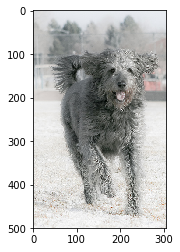

Generated Output: dog is running through the water
Original Desc:  gray fuzzy dog running through snow 
picture_id-  3223224391_be50bf4f43


In [57]:
#full vocabulary with 50 epoch and adam
pic = '3223224391_be50bf4f43'#'2788945468_74a9618cfa'#'2731171552_4a808c7d5a'#'2796801478_8ebd7e550b'
image = test_features[pic]
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Generated Output: "+greedySearch(model,image,max_length))
print("Original Desc: "+ str(test_desc[pic][1][8:-6]))
print("picture_id-  "+str(pic))

In [0]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = greedySearch(model,photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
tokenizer=create_tokenizer(test_desc)
evaluate_model(model,test_desc,test_features,tokenizer,max_length)


BLEU-1: 0.329903
BLEU-2: 0.148406
BLEU-3: 0.090901
BLEU-4: 0.031000


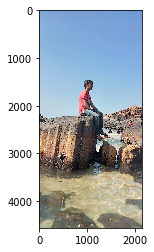

Generated Desc for random pic: man in red shirt is standing on top of mountain
picture_id-  3223224391_be50bf4f43


In [64]:
#Random picture output
image=extract_feature('/content/drive/My Drive/15IT208_15IT101_15IT107_15IT246_major_project/IMG_20190115_150636.jpg')
x=plt.imread('/content/drive/My Drive/15IT208_15IT101_15IT107_15IT246_major_project/IMG_20190115_150636.jpg')
plt.imshow(x)
plt.show()
print("Generated Desc for random pic: "+greedySearch(model,image,max_length))
print("picture_id-  "+str(pic))